In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
import re
import string
import itertools 

In [16]:
# Suppressing warnings
import warnings
warnings.filterwarnings("ignore")

In [17]:
# Load the tweets dataset
tweets = pd.read_csv('/Users/yeshwanthsatyadev/Downloads/Elon_musk.csv', encoding='cp1252')
tweets.drop(['Unnamed: 0'], inplace=True, axis=1)

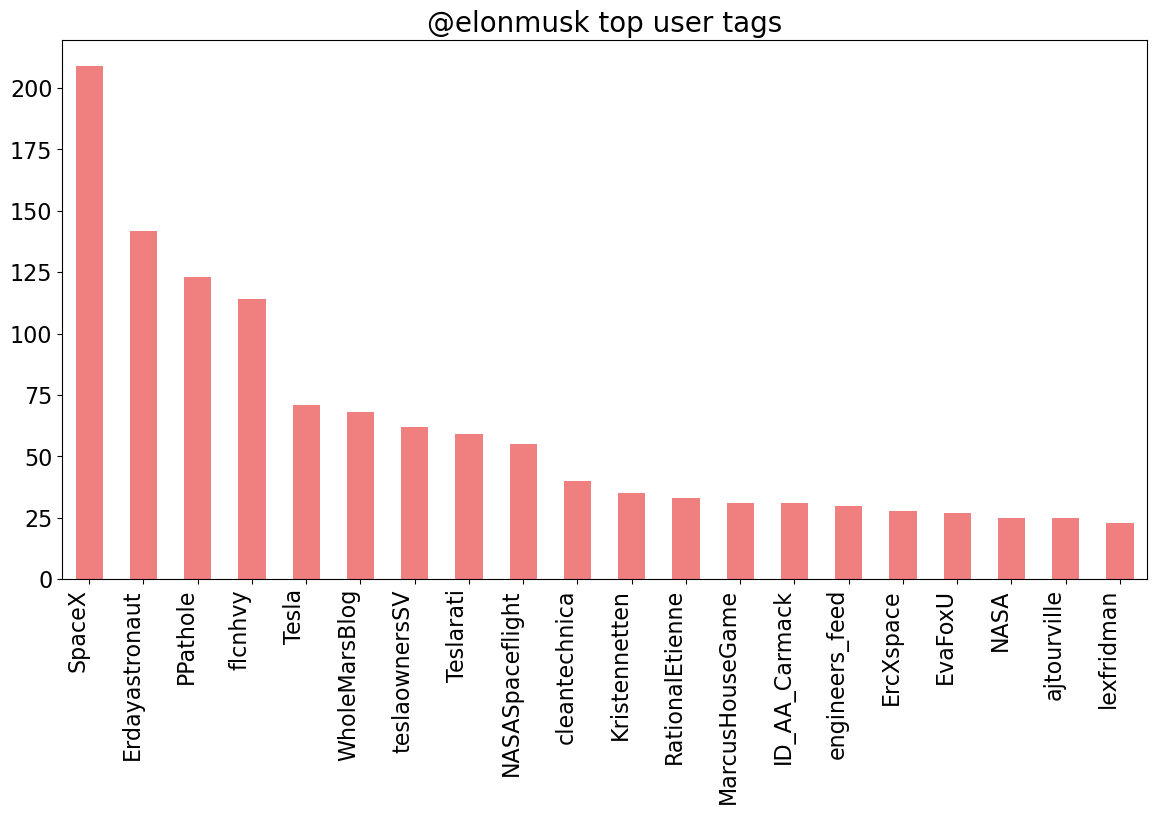

In [18]:
# Extract user tags from tweets
user_tags = list(itertools.chain(*tweets.Text.map(lambda t: [handle.replace(":", "")[1:] for handle in t.split(" ") if '@' in handle.replace(":", "")]).tolist()))
pd.Series(user_tags).value_counts().head(20).plot.bar(figsize=(14, 7), fontsize=16, color='lightcoral')
plt.title('@elonmusk top user tags', fontsize=20)
plt.xticks(rotation=90, ha='right', fontsize=16)
plt.show()


In [19]:
# Clean text data
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub("[0-9" "]+", " ", text)
    text = re.sub('[‘’“”…]', '', text)
    return text

In [20]:
clean = lambda x: clean_text(x)
tweets["Text"] = tweets["Text"].apply(clean)

# Remove stopwords
stop = stopwords.words('english')
tweets['Text'] = tweets['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [22]:
# Create word frequency dataframe using CountVectorizer
vectorizer = CountVectorizer(min_df=1, max_df=0.9)
X = vectorizer.fit_transform(tweets["Text"])
word_freq_df = pd.DataFrame({'term': vectorizer.get_feature_names_out(), 'occurrences': np.asarray(X.sum(axis=0)).ravel().tolist()})
word_freq_df['frequency'] = word_freq_df['occurrences'] / np.sum(word_freq_df['occurrences'])


In [23]:
# Extract top bi-grams and tri-grams
def get_top_n_words(corpus, n, ngram_range=(2, 2)):
    vec = CountVectorizer(ngram_range=ngram_range, max_features=2000).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

top2_words = get_top_n_words(tweets["Text"], n=200, ngram_range=(2, 2))
top2_df = pd.DataFrame(top2_words, columns=["Bi-gram", "Freq"])

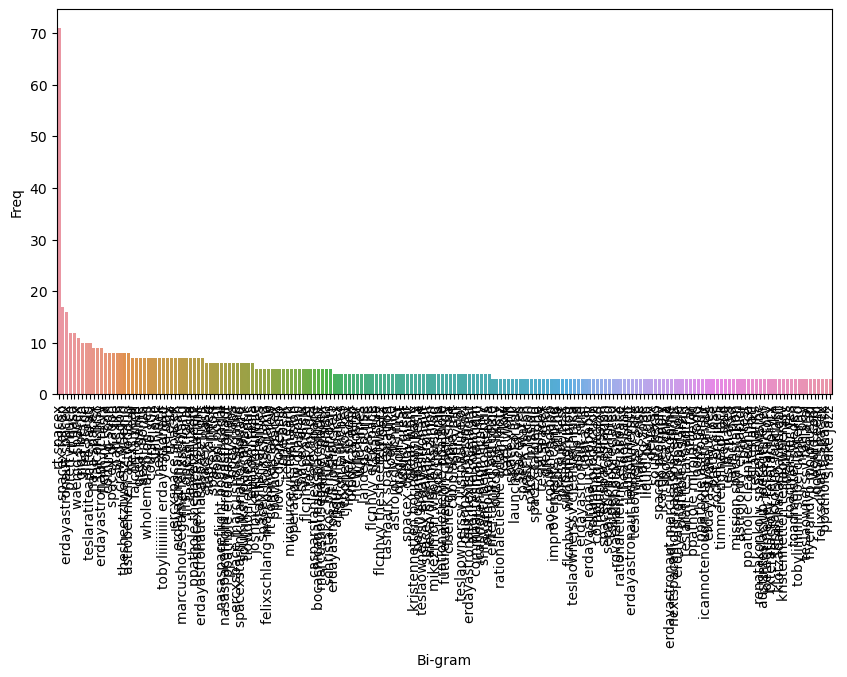

In [25]:
# Visualize top bi-grams
plt.figure(figsize=(10, 5))
sns.barplot(x=top2_df["Bi-gram"], y=top2_df["Freq"])
plt.xticks(rotation=90, ticks=range(len(top2_df["Bi-gram"])), labels=top2_df["Bi-gram"])

plt.show()

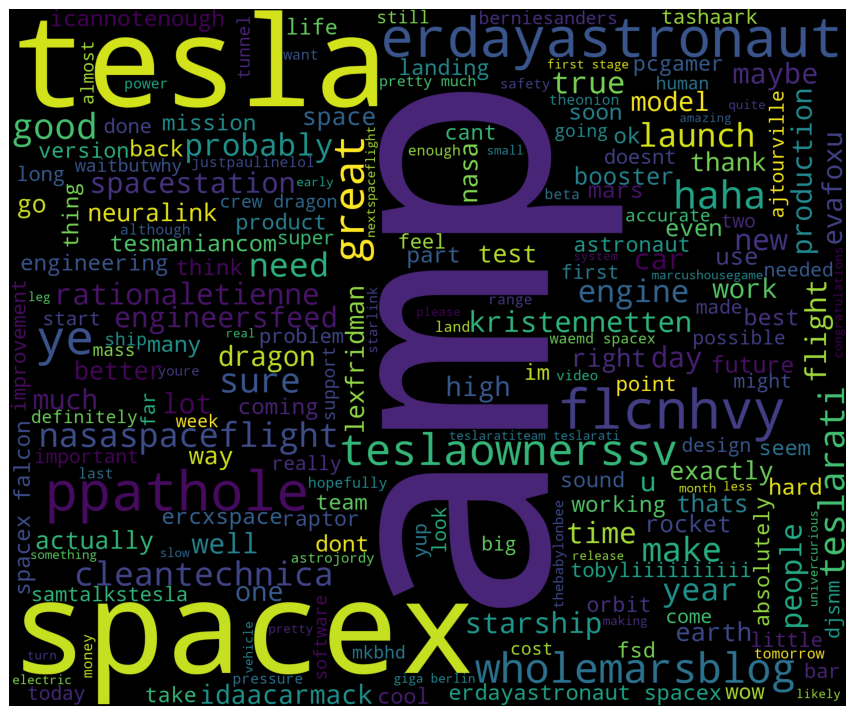

In [26]:
# Generate word cloud for entire corpus
string_total = " ".join(tweets["Text"])
wordcloud = WordCloud(background_color='black', width=1800, height=1500).generate(string_total)
plt.figure(figsize=(12, 12), dpi=90)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [27]:
# Sentiment analysis using TextBlob
def sentiment_analysis(ds):
    sentiment = TextBlob(ds["Text"]).sentiment
    return pd.Series([sentiment.subjectivity, sentiment.polarity])

tweets[["subjectivity", "polarity"]] = tweets.apply(sentiment_analysis, axis=1)

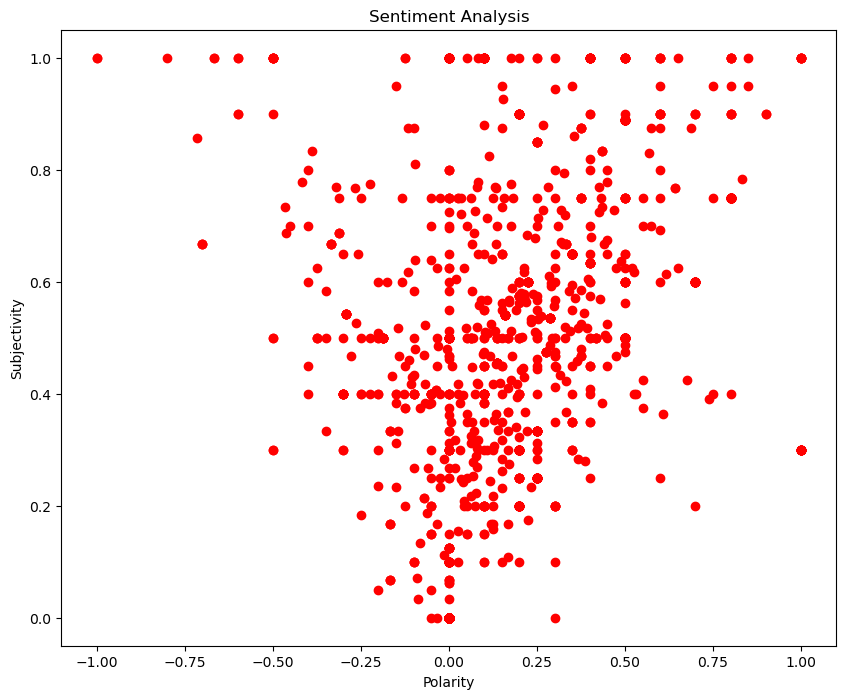

In [28]:
# Visualize sentiment analysis
plt.figure(figsize=(10, 8))
for i in range(0, tweets.shape[0]):
    plt.scatter(tweets["polarity"][i], tweets["subjectivity"][i], color="Red")

plt.title("Sentiment Analysis")
plt.xlabel("Polarity")
plt.ylabel("Subjectivity")
plt.show()


In [29]:
# Sentiment analysis using SentimentIntensityAnalyzer
def fetch_sentiment_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    return 'neg' if polarity_scores['neg'] > polarity_scores['pos'] else 'pos'

In [30]:
# Sentiment analysis using TextBlob
def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    return 'pos' if analysis.sentiment.polarity >= 0 else 'neg'

In [31]:
# Compute negative and positive tweets
tweets["analysis"] = tweets["polarity"].apply(lambda x: "Negative" if x < 0 else ("Neutral" if x == 0 else "Positive"))
positive_tweets = tweets[tweets['analysis'] == 'Positive']
negative_tweets = tweets[tweets['analysis'] == 'Negative']

In [32]:
# Display example positive tweets
print('Positive tweets:')
for _, row in positive_tweets.head(5).iterrows():
    print(' - ' + row['Text'])

Positive tweets:
 - joerogan spotify great interview
 - teslacn congratulations tesla china amazing execution last year next even
 - happy new year ox
 - owensparks flcnhvy haha thanks
 - entertaining outcome likely


In [33]:
# Display example negative tweets
print('\nNegative tweets:')
for _, row in negative_tweets.head(5).iterrows():
    print(' - ' + row['Text'])


Negative tweets:
 - im alien
 - frodo underdoge thought would fail httpstcozgxjfdzzrm
 - freewalletorg app sucks
 - rationaletienne adamklotz starlink staggeringly difficult technical amp economic endeavor however
 - rationaletienne adamklotz spacex needs pass deep chasm negative cash flow next year


In [34]:
# Calculate the percentage of positive tweets
positive_percentage = (len(positive_tweets) / len(negative_tweets)) * 100
print(f"Percentage of positive tweets: {positive_percentage:.2f}%")

Percentage of positive tweets: 422.11%
